In [1]:
import os
import shutil
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# Dataset

## SPANet

* Signal
* '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/ppHhh_mixing/500k_diHiggs_4b_PT40_resonant_mix_train.h5' 500k
* '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/ppHhh_mixing/500k_diHiggs_4b_PT40_resonant_mix_test.h5' 50k
* Background
* '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/resonant/pp4b_mixing/pp4b_SPANET2_split1.h5' 500k
* '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/resonant/pp4b_mixing/pp4b_SPANET2_split2_split1.h5' 50k

In [2]:
def my_rename(old_file, new_file):
    if not os.path.isfile(new_file):
        os.rename(old_file, new_file)
        print(f'{old_file} ---> {new_file}')
    else:
        print(f'{new_file} exist.')

In [3]:
def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

def shuffle_h5(file_path):
    with h5py.File(file_path,'a') as f:
        dataset_keys = get_dataset_keys(f)
        nevent = f[dataset_keys[0]].shape[0]
        print(f'Shuffle {file_path}')
        
        ind_list = list(range(nevent))
        random.shuffle(ind_list)
        for key in dataset_keys:      
            f[key][...] = np.array(f[key])[ind_list]

def split_h5_file(main_file, r=0.9):
    # 將輸入的 HDF5 檔案以 r 的比例分成兩個
    root, ext = os.path.splitext(main_file)
    split_file1 = root + '_split1' + ext
    split_file2 = root + '_split2' + ext

    with h5py.File(main_file, 'r') as f_main:
        dataset_keys = get_dataset_keys(f_main)
        key0 = dataset_keys[0]
        total_size = f_main[key0].shape[0]
        print(f'Size of {main_file}: {total_size}')
        
        sp_size = int(total_size * r)
        if sp_size < 1:
            print(f'The split ratio {r} is too small for the input file size {total_size}.')
            
        with h5py.File(split_file1, 'w') as f_sp1, h5py.File(split_file2, 'w') as f_sp2:    
            
            for key in dataset_keys:
                maxShape = list(f_main[key].maxshape)
                maxShape[0] = None
                f_sp1.create_dataset(key, maxshape=maxShape, data=f_main[key][:sp_size])
                f_sp2.create_dataset(key, maxshape=maxShape, data=f_main[key][sp_size:]) 
            
            print(f'Size of {split_file1}: {f_sp1[key0].shape[0]}')
            print(f'Size of {split_file2}: {f_sp2[key0].shape[0]}')

def split_h5_size(main_file, size=1000):
    # 將輸入的 HDF5 檔案以 size 數目分成兩個
    root, ext = os.path.splitext(main_file)
    split_file1 = root + '_split1' + ext
    split_file2 = root + '_split2' + ext

    with h5py.File(main_file, 'r') as f_main:
        dataset_keys = get_dataset_keys(f_main)
        key0 = dataset_keys[0]
        total_size = f_main[key0].shape[0]
        print(f'Size of {main_file}: {total_size}')
        
        if size > total_size:
            print(f'Split size {size} is greater than the input file size {total_size}.')
            
        with h5py.File(split_file1, 'w') as f_sp1, h5py.File(split_file2, 'w') as f_sp2:    
            sp_size = size

            for key in dataset_keys:
                maxShape = list(f_main[key].maxshape)
                maxShape[0] = None
                f_sp1.create_dataset(key, maxshape=maxShape, data=f_main[key][:sp_size])
                f_sp2.create_dataset(key, maxshape=maxShape, data=f_main[key][sp_size:]) 
            
            print(f'Size of {split_file1}: {f_sp1[key0].shape[0]}')
            print(f'Size of {split_file2}: {f_sp2[key0].shape[0]}')

def merge_h5_file(main_file, *arg):
    # 合併傳入的 HDF5 檔案    
    
    # 檢查傳入檔案結構是否都相同
    same_structure = True
    with h5py.File(main_file, 'r') as f_main:
        main_dataset_keys = get_dataset_keys(f_main)
        for append_file in arg:
            with h5py.File(append_file, 'r') as f_append:
                append_dataset_keys = get_dataset_keys(f_append)    
                if set(main_dataset_keys) != set(append_dataset_keys):
                    same_structure = False
                    print(f"'{main_file}' and '{append_file}' are not same structure, can not be merged.")
                    break

    # 檢查檔案結構是否都相同
    if not same_structure:
        return
    print(f"'{main_file}' and {arg} are same structure, can be merged.")

    root, ext = os.path.splitext(main_file)
    new_file = root + '_merged' + ext

    # 檢查合併檔案是否存在
    if os.path.isfile(new_file):
        print(f'{new_file} exist. Can not copy {main_file} to {new_file}')
        return

    print(f'{new_file} not exist. Copy {main_file} to {new_file}')
    shutil.copyfile(main_file, new_file)

    with h5py.File(new_file, 'a') as f_main:
        key0 = main_dataset_keys[0]
        total_size = f_main[key0].shape[0]
        print(f'Size of {main_file}: {total_size}')

        for append_file in arg:
            with h5py.File(append_file, 'r') as f_append:
                size_of_append = f_append[key0].shape[0]            
                print(f'Size of {append_file}: {size_of_append}')

                total_size += size_of_append
                if size_of_append == 0:
                    continue
                
                for key in main_dataset_keys:
                    f_main[key].resize(total_size, axis=0)
                    f_main[key][-size_of_append:] = f_append[key]
                
                print(f'Size of {new_file}: {f_main[key0].shape[0]}')
    return new_file

def add_class_info(file_path, signal):       
    # 添加 class 資訊
    with h5py.File(file_path, 'a') as f:
        nevent = f['INPUTS/Source/pt'].shape[0]
        try:
            f.create_dataset('CLASSIFICATIONS/EVENT/signal', (nevent,), maxshape=(None,), dtype='<i8')
        except:
            pass
        f['CLASSIFICATIONS/EVENT/signal'].resize(nevent, axis=0) 
        f['CLASSIFICATIONS/EVENT/signal'][:] = signal
        
        print(f'Add class to {file_path}')

In [4]:
def create_mix_sample(sig_path, bkg_path, f1, f2, N1, N2, output_path):
    # sig_path, bkg_path .h5 file
    # f1, f2: signal fractions of mixing sample
    # N1, N2: number of mixing sample
    
    shuffle_h5(sig_path)
    shuffle_h5(bkg_path)

    n_sig_1, n_sig_2 = int(N1 * f1), int(N2 * f2)
    n_bkg_1, n_bkg_2 = N1 - n_sig_1, N2 - n_sig_2
    
    # Split signal and background sample
    split_h5_size(sig_path, n_sig_1)
    root, ext = os.path.splitext(sig_path)
    mix_data1_s = f'{root}_split1{ext}'
    split_h5_size(f'{root}_split2{ext}', n_sig_2)
    mix_data2_s = f'{root}_split2_split1{ext}'

    os.remove(f'{root}_split2{ext}')
    os.remove(f'{root}_split2_split2{ext}')

    split_h5_size(bkg_path, n_bkg_1)
    root, ext = os.path.splitext(bkg_path)
    mix_data1_b = f'{root}_split1{ext}'  
    split_h5_size(f'{root}_split2{ext}', n_bkg_2)
    mix_data2_b = f'{root}_split2_split1{ext}'

    os.remove(f'{root}_split2{ext}')
    os.remove(f'{root}_split2_split2{ext}')

    # Generate mixed sample
    old_name = merge_h5_file(mix_data1_s, mix_data1_b)
    my_rename(old_name, './Sample/M1_tmp.h5')
    add_class_info('./Sample/M1_tmp.h5', 1)

    old_name = merge_h5_file(mix_data2_s, mix_data2_b)
    my_rename(old_name, './Sample/M2_tmp.h5')
    add_class_info('./Sample/M2_tmp.h5', 0)

    os.remove(mix_data1_s)
    os.remove(mix_data1_b)
    os.remove(mix_data2_s)
    os.remove(mix_data2_b)

    old_name = merge_h5_file('./Sample/M1_tmp.h5', './Sample/M2_tmp.h5')
    my_rename(old_name, output_path)

    os.remove('./Sample/M1_tmp.h5')
    os.remove('./Sample/M2_tmp.h5')

    shuffle_h5(output_path)

In [30]:
sig_path = './Sample/SPANet/signal_train.h5'
bkg_path = './Sample/SPANet/background_train.h5'
N1, N2 = 500000, 500000

for i in range(11):
    f1 = round(i * 0.1,2)
    f2 = round(1 - f1, 2)
    
    output_path = f'../SPANet2/data/CWoLa/mixing_sample_{i:02}.h5'

    create_mix_sample(sig_path, bkg_path, f1, f2, N1, N2, output_path)

Dataset size: 500000
Dataset size: 500000
Size of ./Sample/signal_train.h5: 500000
The split ratio 0.0 is too small for the input file size 500000.
Size of ./Sample/signal_train_split1.h5: 0
Size of ./Sample/signal_train_split2.h5: 500000
Size of ./Sample/background_train.h5: 500000
Size of ./Sample/background_train_split1.h5: 500000
Size of ./Sample/background_train_split2.h5: 0
'./Sample/signal_train_split1.h5' and ('./Sample/background_train_split1.h5',) are same structure, can be merged.
./Sample/signal_train_split1_merged.h5 not exist. Copy ./Sample/signal_train_split1.h5 to ./Sample/signal_train_split1_merged.h5
Size of ./Sample/signal_train_split1.h5: 0
Size of ./Sample/background_train_split1.h5: 500000
Size of ./Sample/signal_train_split1_merged.h5: 500000
./Sample/signal_train_split1_merged.h5 ---> ./Sample/M1_tmp.h5
Add class to ./Sample/M1_tmp.h5
'./Sample/signal_train_split2.h5' and ('./Sample/background_train_split2.h5',) are same structure, can be merged.
./Sample/signal

In [6]:
f1 = 0.5
f2 = 0.5
N1, N2 = 500000, 500000
sig_path = './Sample/SPANet/signal_train.h5'
bkg_path = './Sample/SPANet/background_train.h5'

output_path = f'../SPANet2/data/CWoLa/mixing_sample_05.h5'

create_mix_sample(sig_path, bkg_path, f1, f2, N1, N2, output_path)

Shuffle ./Sample/SPANet/signal_train.h5
Shuffle ./Sample/SPANet/background_train.h5
Size of ./Sample/SPANet/signal_train.h5: 500000
Size of ./Sample/SPANet/signal_train_split1.h5: 250000
Size of ./Sample/SPANet/signal_train_split2.h5: 250000
Size of ./Sample/SPANet/signal_train_split2.h5: 250000
Size of ./Sample/SPANet/signal_train_split2_split1.h5: 250000
Size of ./Sample/SPANet/signal_train_split2_split2.h5: 0
Size of ./Sample/SPANet/background_train.h5: 500000
Size of ./Sample/SPANet/background_train_split1.h5: 250000
Size of ./Sample/SPANet/background_train_split2.h5: 250000
Size of ./Sample/SPANet/background_train_split2.h5: 250000
Size of ./Sample/SPANet/background_train_split2_split1.h5: 250000
Size of ./Sample/SPANet/background_train_split2_split2.h5: 0
'./Sample/SPANet/signal_train_split1.h5' and ('./Sample/SPANet/background_train_split1.h5',) are same structure, can be merged.
./Sample/SPANet/signal_train_split1_merged.h5 not exist. Copy ./Sample/SPANet/signal_train_split1.h5

## DNN

* './Sample/DNN/'

In [21]:
def create_mix_sample_npy(file_path, f1, f2, N1, N2, output_path):
    data_dict = np.load(file_path, allow_pickle=True).item()

    sig_data = data_dict['data'][data_dict['label']==1]
    bkg_data = data_dict['data'][data_dict['label']==0]

    n_sig_1, n_sig_2 = int(N1 * f1), int(N2 * f2)
    n_bkg_1, n_bkg_2 = N1 - n_sig_1, N2 - n_sig_2

    n_sig = n_sig_1 + n_sig_2
    n_bkg = n_bkg_1 + n_bkg_2
    
    if n_sig > sig_data.shape[0] or n_bkg > bkg_data.shape[0]:
        print('The number of input samples is not enough.')
        return
    sig_data_1, sig_data_2 = sig_data[:n_sig_1], sig_data[n_sig_1:n_sig]    
    bkg_data_1, bkg_data_2 = bkg_data[:n_bkg_1], bkg_data[n_bkg_1:n_bkg]
    # sig_data_1, sig_data_2 = sig_data[:int(n_sig * f1)], sig_data[int(n_sig * f1):]
    # bkg_data_1, bkg_data_2 = bkg_data[:int(n_bkg * f2)], bkg_data[int(n_bkg * f2):]
    
    data = np.vstack([sig_data_1, bkg_data_1, sig_data_2, bkg_data_2])
    label = np.array([1] * (n_sig_1+ n_bkg_1) + [0] * (n_sig_2 + n_bkg_2))
    
    # shuffle
    ind_list = list(range(len(label)))
    random.shuffle(ind_list)

    data = data[ind_list]
    label = label[ind_list]

    npy_dict = {'data': data, 'label': label}

    np.save(output_path, npy_dict)

In [51]:
file_path = './Sample/DNN/SPANet_high_level_train.npy'
N1, N2 = 500000, 500000
for i in tqdm(range(11)):
    f1 = round(i * 0.1,2)
    f2 = round(1 - f1, 2)
    output_path = f'./Sample/DNN/mixing_sample_{i:02}.npy'

    create_mix_sample_npy(file_path, f1, f2, N1, N2, output_path)

In [22]:
file_path = './Sample/DNN/SPANet_high_level_train.npy'
N1, N2 = 50000, 50000
f1, f2 = 0.5, 0.5
output_path = f'./Sample/DNN/mixing_sample.npy'

create_mix_sample_npy(file_path, f1, f2, N1, N2, output_path)

100000


# Training

## SPANet

In [2]:
import json

with open('/home/r10222035/SPANet2/options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_cwola_no_pairing_template.json', 'r') as file:
    data = json.load(file)

for i in range(11):
    data['training_file'] = f'./data/CWoLa/mixing_sample_{i:02}.h5'
    with open(f'/home/r10222035/SPANet2/options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_no_pair_cwola_{i:02}.json', 'w') as file:
        json.dump(data, file, indent=4)


In [3]:
for i in range(11):
    option_file = f'options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_no_pair_cwola_{i:02}.json'
    name = f'CWoLa_{i:02}_no_pair'

    cmd = f'python -m spanet.train -of {option_file} --log_dir CWoLa  --name {name} --gpus 1'
    print(cmd)

python -m spanet.train -of options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_no_pair_cwola_00.json --log_dir CWoLa  --name CWoLa_00_no_pair --gpus 1
python -m spanet.train -of options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_no_pair_cwola_01.json --log_dir CWoLa  --name CWoLa_01_no_pair --gpus 1
python -m spanet.train -of options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_no_pair_cwola_02.json --log_dir CWoLa  --name CWoLa_02_no_pair --gpus 1
python -m spanet.train -of options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_no_pair_cwola_03.json --log_dir CWoLa  --name CWoLa_03_no_pair --gpus 1
python -m spanet.train -of options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_no_pair_cwola_04.json --log_dir CWoLa  --name CWoLa_04_no_pair --gpus 1
python -m spanet.train -of options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_no_pair_cwola_05.json --log_dir CWoLa  --name CWoLa_05_no_pair --gpus 1
python -m spanet.train -of options_files/CWoLa/500k_diHiggs_4b_PT40_resonant_no_pair_cwola_06.json --log_d

### Predict

In [2]:
def SPANET2_predict(log_dir, test_file, output_file):
    cmd = f'python -m spanet.predict {log_dir} {output_file} -tf {test_file} --gpu'
    print(cmd)

In [4]:
for i in range(11):
    log_dir = f'/home/r10222035/SPANet2/CWoLa/CWoLa_{i:02}_no_pair/version_0'
    test_file = f'/home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test.h5'
    output_file = f'/home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test-CWoLa_{i:02}_no_pair-predict.h5' 

    SPANET2_predict(log_dir, test_file, output_file)

python -m spanet.predict /home/r10222035/SPANet2/CWoLa/CWoLa_00_no_pair/version_0 /home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test-CWoLa_00_no_pair-predict.h5 -tf /home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test.h5 --gpu
python -m spanet.predict /home/r10222035/SPANet2/CWoLa/CWoLa_01_no_pair/version_0 /home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test-CWoLa_01_no_pair-predict.h5 -tf /home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test.h5 --gpu
python -m spanet.predict /home/r10222035/SPANet2/CWoLa/CWoLa_02_no_pair/version_0 /home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test-CWoLa_02_no_pair-predict.h5 -tf /home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test.h5 --gpu
python -m spanet.predict /home/r10222035/SPANet2/CWoLa/CWoLa_03_no_pair/version_0 /home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_

In [ ]:
log_dir = f'/home/r10222035/SPANet2/CWoLa/CWoLa_05_no_pair/version_0'
test_file = f'/home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test.h5'
output_file = f'/home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test-CWoLa_05_no_pair-predict.h5' 

SPANET2_predict(log_dir, test_file, output_file)

python -m spanet.predict /home/r10222035/SPANet2/CWoLa/CWoLa/version_0/ /home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test-CWoLa-predict.h5 -tf /home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test.h5 --gpu


## DNN

In [50]:
for i in range(11):
    cmd = f'python train_DNN.py {i}'
    print(cmd)

python train_DNN.py 0
python train_DNN.py 1
python train_DNN.py 2
python train_DNN.py 3
python train_DNN.py 4
python train_DNN.py 5
python train_DNN.py 6
python train_DNN.py 7
python train_DNN.py 8
python train_DNN.py 9
python train_DNN.py 10


In [1]:
for i in range(11):
    cmd = f'python test_DNN.py {i}'
    print(cmd)

python test_DNN.py 0
python test_DNN.py 1
python test_DNN.py 2
python test_DNN.py 3
python test_DNN.py 4
python test_DNN.py 5
python test_DNN.py 6
python test_DNN.py 7
python test_DNN.py 8
python test_DNN.py 9
python test_DNN.py 10


# Result

## SPANet

In [2]:
file_path = '/home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test.h5'
with h5py.File(file_path, 'r') as f:
    y_test = f['CLASSIFICATIONS/EVENT/signal'][...]
    
file_path = '/home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test-CWoLa_05_no_pair-predict.h5'
with h5py.File(file_path, 'r') as f:
    y_prob = f['CLASSIFICATIONS/EVENT/signal'][...]

100%|██████████| 1001/1001 [00:06<00:00, 155.70it/s]


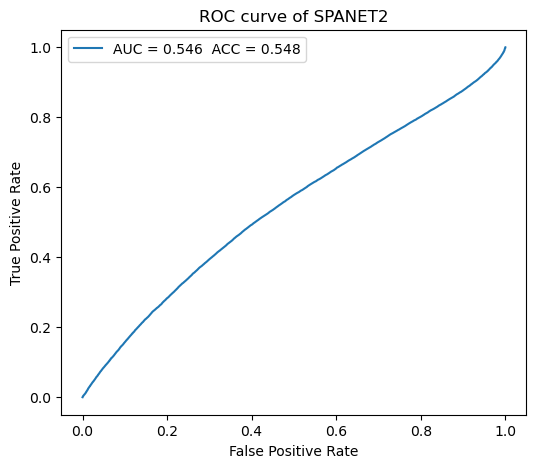

In [3]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

i = 1
AUC = roc_auc_score(y_test,  y_prob[:,i])

if AUC < 0.5:
    i = 0
    AUC = roc_auc_score(y_test,  y_prob[:,i])

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,i])

accuracy_scores = []
# 最多用 1000 個
if len(thresholds) > 1000:
    thresholds = np.percentile(thresholds, np.linspace(0,100,1001))

for threshold in tqdm(thresholds):
    accuracy_scores.append(accuracy_score(y_test,  y_prob[:,i]>threshold))

accuracies = np.array(accuracy_scores)
ACC = accuracies.max() 

ax.plot(fpr, tpr, label = f'AUC = {AUC:.3f}  ACC = {ACC:.3f}')

ax.set_title(f'ROC curve of SPANET2')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# plt.savefig(f'figures/ROC_DNN_{pairing_method}.png', facecolor='White', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
file_path = '/home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test.h5'
with h5py.File(file_path, 'r') as f:
    y_test = f['CLASSIFICATIONS/EVENT/signal'][...]
    
for i in range(11):
    f1 = round(i * 0.1,2)
    f2 = round(1 - f1, 2)

    file_path = f'/home/r10222035/SPANet2/data/CWoLa/500k_diHiggs_4b_PT40_resonant_mix_class_test-CWoLa_{i:02}_no_pair-predict.h5'
    with h5py.File(file_path, 'r') as f:
        y_prob = f['CLASSIFICATIONS/EVENT/signal'][...]
        
    label = 1
    AUC = roc_auc_score(y_test,  y_prob[:,label])

    if AUC < 0.5:
        label = 0
        AUC = roc_auc_score(y_test,  y_prob[:,label])
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,label])

    accuracy_scores = []
    # 最多用 1000 個
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0,100,1001))

    for threshold in tqdm(thresholds):
        accuracy_scores.append(accuracy_score(y_test,  y_prob[:,label]>threshold))

    accuracies = np.array(accuracy_scores)
    ACC = accuracies.max() 
    
    
    file_name = 'CWoLa_training_results.csv'
    
    data_dict = {
                'Version': ['No pairing'],
                'Fraction 1': [f1],
                'Fraction 2': [f2],
                'Classification ACC': [ACC],
                'Classification AUC': [AUC],
                }
        
    df = pd.DataFrame(data_dict)
    if os.path.isfile(file_name):
        training_results_df = pd.read_csv(file_name)
        pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
    else:
        df.to_csv(file_name, index=False)

100%|██████████| 1001/1001 [00:06<00:00, 152.68it/s]


In [2]:
file_name = './CWoLa_training_results.csv'
df = pd.read_csv(file_name)

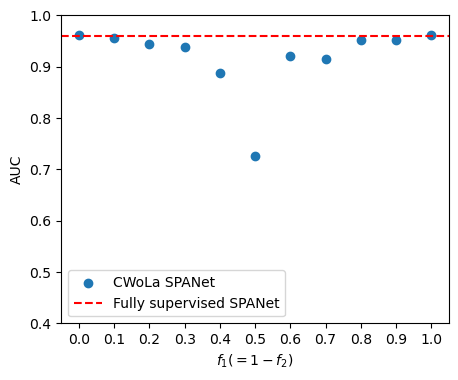

In [3]:
AUC = df[df['Version'] != 'No pairing']['Classification AUC']
f1 = df[df['Version'] != 'No pairing']['Fraction 1']
fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.scatter(f1, AUC, label='CWoLa SPANet')
ax.set_xticks(np.linspace(0,1,11))

ax.set_xlabel('$f_1 (= 1 - f_2)$')
ax.set_ylabel('AUC')

y_value = 0.960
ax.axhline(y_value, color='red', linestyle='--', label='Fully supervised SPANet')

ax.set_ylim(0.4,1)

ax.legend()
plt.savefig('./figures/CWoLa_SPANet.pdf', facecolor='White', dpi=300, bbox_inches='tight')
plt.show()

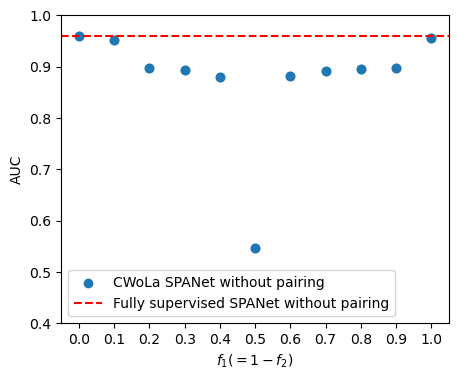

In [4]:
AUC = df[df['Version'] == 'No pairing']['Classification AUC']
f1 = df[df['Version'] == 'No pairing']['Fraction 1']
fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.scatter(f1, AUC, label='CWoLa SPANet without pairing')
ax.set_xticks(np.linspace(0,1,11))

ax.set_xlabel('$f_1 (= 1 - f_2)$')
ax.set_ylabel('AUC')

y_value = 0.960
ax.axhline(y_value, color='red', linestyle='--', label='Fully supervised SPANet without pairing')

ax.set_ylim(0.4,1)

ax.legend()
plt.savefig('./figures/CWoLa_SPANet_no_pair.pdf', facecolor='White', dpi=300, bbox_inches='tight')
plt.show()

## DNN

In [5]:
file_name = './DNN/DNN_CWoLa_training_results.csv'
df = pd.read_csv(file_name)

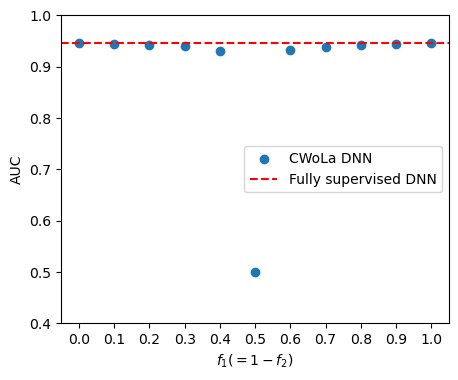

In [6]:
AUC = df['AUC']
f1 = df['Fraction 1']
fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.scatter(f1, AUC, label='CWoLa DNN')
ax.set_xticks(np.linspace(0,1,11))

ax.set_xlabel('$f_1 (= 1 - f_2)$')
ax.set_ylabel('AUC')

y_value = 0.946  
ax.axhline(y_value, color='red', linestyle='--', label='Fully supervised DNN')

ax.set_ylim(0.4,1)

ax.legend()
plt.savefig('./figures/CWoLa_DNN.pdf', facecolor='White', dpi=300, bbox_inches='tight')
plt.show()